In [2]:
import tensorflow as tf
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from PIL import Image, ImageEnhance

from utils import *

%load_ext autoreload
%autoreload 2
    
MODEL_PATH = "models/3conv_1pool/"

In [66]:
(X_train_60000, y_train_60000), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [4]:
samples_for_training = 60000
X_train, y_train = X_train_60000[:samples_for_training], y_train_60000[:samples_for_training]

## Data visualization

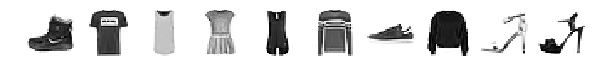

In [4]:
samples_to_show = 10
plt.figure(figsize=(10,10))
for iteration in range(samples_to_show):
    plt.subplot(samples_to_show, 10, iteration + 1)
    plot_image(X_train[iteration])

In [5]:
y_train[:samples_to_show]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5], dtype=uint8)

## Explanation

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

## Neural Network

In [5]:
height = 28
width = 28
channels = 1

### 3 conv, 1 pool, BN + Dropout

In [7]:
tf.reset_default_graph()

conv1_fmaps = 16
conv1_ksize = 4
conv1_stride = 1

conv2_fmaps = 32
conv2_ksize = 4
conv2_stride = 2

conv3_fmaps = 64
conv3_ksize = 4
conv3_stride = 2

n_fc1 = 200
n_fc2 = 100
n_outputs = 10

in_training_mode = tf.placeholder_with_default(False, shape=[], name='training')
dropout_rate = 0.5


with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, height, width], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    X_normed = tf.layers.batch_normalization(X_reshaped, momentum=0.9, training=in_training_mode) 
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X_normed, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding="SAME",
                         activation=None, name="conv1")
conv1_BN = tf.layers.batch_normalization(conv1, momentum=0.9, training=in_training_mode)
conv1_relu = tf.nn.relu(conv1_BN) 

conv2 = tf.layers.conv2d(conv1_relu, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding="SAME",
                         activation=None, name="conv2")

conv2_BN = tf.layers.batch_normalization(conv2, momentum=0.9, training=in_training_mode)
conv2_relu = tf.nn.relu(conv2_BN) 

pool1 = tf.nn.max_pool(conv2_relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID", name="pool1")
    

conv3 = tf.layers.conv2d(pool1, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding="SAME",
                         activation=None, name="conv3")    
conv3_BN = tf.layers.batch_normalization(conv3, momentum=0.9, training=in_training_mode)
conv3_relu = tf.nn.relu(conv3_BN) 

'''with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(conv3_relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool2_flat = tf.reshape(conv3_relu, shape=[-1, pool2_fmaps * int(pool2.shape[1]) * int(pool2.shape[1])])
'''
conv3_flat = tf.reshape(conv3_relu, shape=[-1, conv3_fmaps * int(conv3_relu.shape[1]) * int(conv3_relu.shape[1])])
                        
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(conv3_flat, n_fc1, activation=tf.nn.relu, name="fc1")
    fc1_drop = tf.layers.dropout(fc1, dropout_rate, training=in_training_mode)

with tf.name_scope("fc2"):
    fc2 = tf.layers.dense(fc1_drop, n_fc2, activation=tf.nn.relu, name="fc2")
    fc2_drop = tf.layers.dropout(fc2, dropout_rate, training=in_training_mode)
    
with tf.name_scope("output"):
    logits = tf.layers.dense(fc2_drop, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    loss_ = tf.summary.scalar('loss', loss)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy_train = tf.reduce_mean(tf.cast(correct, tf.float32))
    accuracy_test = tf.reduce_mean(tf.cast(correct, tf.float32))
    
    accuracy_train_ = tf.summary.scalar('accuracy_train', accuracy_train)
    accuracy_test_ = tf.summary.scalar('accuracy_test', accuracy_test)

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

### 3 conv, 1 pool, BN

In [133]:
tf.reset_default_graph()

conv1_fmaps = 16
conv1_ksize = 4
conv1_stride = 1

conv2_fmaps = 32
conv2_ksize = 4
conv2_stride = 2

pool1_fmaps = conv1_fmaps

conv3_fmaps = 64
conv3_ksize = 4
conv3_stride = 2

conv4_fmaps = 48
conv4_ksize = 4
conv4_stride = 2

pool2_fmaps = conv3_fmaps

n_fc1 = 200
n_fc2 = 100
n_outputs = 10

in_training_mode = tf.placeholder_with_default(False, shape=[], name='training')
#dropout_rate = 0.5


with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, height, width], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    X_normed = tf.layers.batch_normalization(X_reshaped, momentum=0.9, training=in_training_mode) 
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X_normed, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding="SAME",
                         activation=None, name="conv1")
conv1_BN = tf.layers.batch_normalization(conv1, momentum=0.9, training=in_training_mode)
conv1_relu = tf.nn.relu(conv1_BN) 

conv2 = tf.layers.conv2d(conv1_relu, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding="SAME",
                         activation=None, name="conv2")

conv2_BN = tf.layers.batch_normalization(conv2, momentum=0.9, training=in_training_mode)
conv2_relu = tf.nn.relu(conv2_BN) 

pool1 = tf.nn.max_pool(conv2_relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID", name="pool1")
    

conv3 = tf.layers.conv2d(pool1, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding="SAME",
                         activation=None, name="conv3")    
conv3_BN = tf.layers.batch_normalization(conv3, momentum=0.9, training=in_training_mode)
conv3_relu = tf.nn.relu(conv3_BN) 

'''with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(conv3_relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool2_flat = tf.reshape(conv3_relu, shape=[-1, pool2_fmaps * int(pool2.shape[1]) * int(pool2.shape[1])])
'''
conv3_flat = tf.reshape(conv3_relu, shape=[-1, conv3_fmaps * int(conv3_relu.shape[1]) * int(conv3_relu.shape[1])])
                        
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(conv3_flat, n_fc1, activation=tf.nn.relu, name="fc1")
    #fc1_drop = tf.layers.dropout(fc1, dropout_rate, training=in_training_mode)

with tf.name_scope("fc2"):
    fc2 = tf.layers.dense(fc1, n_fc2, activation=tf.nn.relu, name="fc2")
    #fc2_drop = tf.layers.dropout(fc2, dropout_rate, training=in_training_mode)
    
with tf.name_scope("output"):
    logits = tf.layers.dense(fc2, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    loss_ = tf.summary.scalar('loss', loss)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy_train = tf.reduce_mean(tf.cast(correct, tf.float32))
    accuracy_test = tf.reduce_mean(tf.cast(correct, tf.float32))
    
    accuracy_train_ = tf.summary.scalar('accuracy_train', accuracy_train)
    accuracy_test_ = tf.summary.scalar('accuracy_test', accuracy_test)

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

### 3 conv, 1 pool, Dropout

In [131]:
tf.reset_default_graph()

conv1_fmaps = 16
conv1_ksize = 4
conv1_stride = 1

conv2_fmaps = 32
conv2_ksize = 4
conv2_stride = 2

conv3_fmaps = 64
conv3_ksize = 4
conv3_stride = 2

n_fc1 = 200
n_fc2 = 100
n_outputs = 10

in_training_mode = tf.placeholder_with_default(False, shape=[], name='training')
dropout_rate = 0.5


with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, height, width], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding="SAME",
                         activation=tf.nn.relu, name="conv1")

conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding="SAME",
                         activation=tf.nn.relu, name="conv2")
    
pool1 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID", name="pool1")

conv3 = tf.layers.conv2d(pool1, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding="SAME",
                         activation=tf.nn.relu, name="conv3") 

'''with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(conv3_relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool2_flat = tf.reshape(conv3_relu, shape=[-1, pool2_fmaps * int(pool2.shape[1]) * int(pool2.shape[1])])
'''
conv3_flat = tf.reshape(conv3, shape=[-1, conv3_fmaps * int(conv3.shape[1]) * int(conv3.shape[1])])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(conv3_flat, n_fc1, activation=tf.nn.relu, name="fc1")
    fc1_drop = tf.layers.dropout(fc1, dropout_rate, training=in_training_mode)

with tf.name_scope("fc2"):
    fc2 = tf.layers.dense(fc1_drop, n_fc2, activation=tf.nn.relu, name="fc2")
    fc2_drop = tf.layers.dropout(fc2, dropout_rate, training=in_training_mode)
    
with tf.name_scope("output"):
    logits = tf.layers.dense(fc2_drop, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("training"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    loss_ = tf.summary.scalar('loss', loss)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy_train = tf.reduce_mean(tf.cast(correct, tf.float32))
    accuracy_test = tf.reduce_mean(tf.cast(correct, tf.float32))
    
    accuracy_train_ = tf.summary.scalar('accuracy_train', accuracy_train)
    accuracy_test_ = tf.summary.scalar('accuracy_test', accuracy_test)

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

### 3 conv, 1 pool, No reg

In [135]:
tf.reset_default_graph()

conv1_fmaps = 16
conv1_ksize = 4
conv1_stride = 1

conv2_fmaps = 32
conv2_ksize = 4
conv2_stride = 2

pool1_fmaps = conv1_fmaps

conv3_fmaps = 64
conv3_ksize = 4
conv3_stride = 2

pool2_fmaps = conv3_fmaps

n_fc1 = 200
n_fc2 = 100
n_outputs = 10

in_training_mode = tf.placeholder_with_default(False, shape=[], name='training')


with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, height, width], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding="SAME",
                         activation=tf.nn.relu, name="conv1")

conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding="SAME",
                         activation=tf.nn.relu, name="conv2")
    
pool1 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID", name="pool1")

conv3 = tf.layers.conv2d(pool1, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding="SAME",
                         activation=tf.nn.relu, name="conv3") 

'''with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(conv3_relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool2_flat = tf.reshape(conv3_relu, shape=[-1, pool2_fmaps * int(pool2.shape[1]) * int(pool2.shape[1])])
'''
conv3_flat = tf.reshape(conv3, shape=[-1, conv3_fmaps * int(conv3.shape[1]) * int(conv3.shape[1])])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(conv3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("fc2"):
    fc2 = tf.layers.dense(fc1, n_fc2, activation=tf.nn.relu, name="fc2")
    
with tf.name_scope("output"):
    logits = tf.layers.dense(fc2, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("training"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    loss_ = tf.summary.scalar('loss', loss)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy_train = tf.reduce_mean(tf.cast(correct, tf.float32))
    accuracy_test = tf.reduce_mean(tf.cast(correct, tf.float32))
    
    accuracy_train_ = tf.summary.scalar('accuracy_train', accuracy_train)
    accuracy_test_ = tf.summary.scalar('accuracy_test', accuracy_test)

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

## Increasing dataset

In [57]:
samples_to_show = 10

#### Testing how to change contrast (zoom and rotation have already been tested in previous notebook)

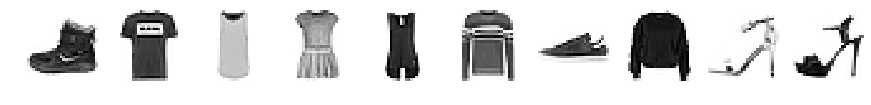

In [58]:
plt.figure(figsize=(15,50)) # not shown in the book
for iteration in range(samples_to_show):
    plt.subplot(samples_to_show, 10, iteration + 1)
    plot_image(X_train[iteration])

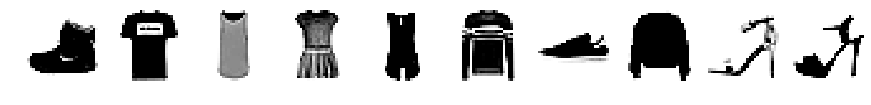

In [59]:
plt.figure(figsize=(15,50)) # not shown in the book
for iteration in range(samples_to_show):
    plt.subplot(samples_to_show, 10, iteration + 1)
    plot_image(np.array(ImageEnhance.Contrast(Image.fromarray(X_train[iteration])).enhance(2)))

#### Creating a dataset artificially increased

In [63]:
X_train_zoom1 = X_train.copy()
X_train_zoom2 = X_train.copy()
X_train_rotate1 = X_train.copy()
X_train_rotate2 = X_train.copy()
X_train_contrast1 = X_train.copy()
X_train_contrast2 = X_train.copy()

for iteration in range(samples_for_training):
    X_train_zoom1[iteration] = clipped_zoom(X_train_zoom[iteration], 0.95)
    X_train_zoom2[iteration] = clipped_zoom(X_train_zoom[iteration], 0.90)

for iteration in range(samples_for_training):
    X_train_rotate1[iteration] = rotate(X_train_rotate1[iteration], 5, reshape=False)    
    X_train_rotate2[iteration] = rotate(X_train_rotate2[iteration], -5, reshape=False)

for iteration in range(samples_for_training):
    X_train_contrast1[iteration] = np.array(ImageEnhance.Contrast(Image.fromarray(X_train[iteration])).enhance(2))   
    X_train_contrast2[iteration] = np.array(ImageEnhance.Contrast(Image.fromarray(X_train[iteration])).enhance(3))

In [64]:
X_train_artificially_increased = np.concatenate((X_train, X_train_zoom1, X_train_zoom2,X_train_rotate1,X_train_rotate2,X_train_contrast1,X_train_contrast2), axis=0)
X_train_artificially_increased.shape

(420000, 28, 28)

In [65]:
y_train_artificially_increased = np.concatenate((y_train,y_train,y_train,y_train,y_train,y_train,y_train), axis=0)
y_train_artificially_increased.shape

(420000,)

## Training

In [11]:
n_epochs = 30
batch_size = 100

now = datetime.now()
logdir = "tf_logs/" + now.strftime("3conv_1pool_BN_Dropout_DatasetIncreasedArtBy7") + "/"

with tf.Session() as sess:
    merged = tf.summary.merge([accuracy_train_,loss_])
    tf_tensorboard_writer = tf.summary.FileWriter('./'+logdir, sess.graph)    
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train_artificially_increased, y_train_artificially_increased, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, in_training_mode : True})       
        print(epoch, "Last batch accuracy:", accuracy_train.eval(feed_dict={X: X_batch, y: y_batch}), "Test accuracy:", accuracy_test.eval(feed_dict={X: X_test, y: y_test}))
        
        summary_str = sess.run(merged, feed_dict={X: X_batch, y: y_batch})
        test_summary_str = sess.run(accuracy_test_, feed_dict={X: X_test, y: y_test})
        tf_tensorboard_writer.add_summary(summary_str, epoch) 
        tf_tensorboard_writer.add_summary(test_summary_str, epoch) 
        save_path = saver.save(sess, MODEL_PATH + "model")
        
tf_tensorboard_writer.close()


0 Last batch accuracy: 0.91 Test accuracy: 0.8726
1 Last batch accuracy: 0.91 Test accuracy: 0.8895
2 Last batch accuracy: 0.84 Test accuracy: 0.8997
3 Last batch accuracy: 0.94 Test accuracy: 0.9027
4 Last batch accuracy: 0.93 Test accuracy: 0.8952
5 Last batch accuracy: 0.91 Test accuracy: 0.9082
6 Last batch accuracy: 0.92 Test accuracy: 0.9043
7 Last batch accuracy: 0.95 Test accuracy: 0.9095
8 Last batch accuracy: 0.95 Test accuracy: 0.9161
9 Last batch accuracy: 0.96 Test accuracy: 0.9126
10 Last batch accuracy: 0.95 Test accuracy: 0.9122
11 Last batch accuracy: 0.95 Test accuracy: 0.9159
12 Last batch accuracy: 0.98 Test accuracy: 0.9127
13 Last batch accuracy: 0.96 Test accuracy: 0.9141
14 Last batch accuracy: 0.99 Test accuracy: 0.9158
15 Last batch accuracy: 0.98 Test accuracy: 0.9142
16 Last batch accuracy: 0.93 Test accuracy: 0.9173
17 Last batch accuracy: 0.96 Test accuracy: 0.9169
18 Last batch accuracy: 0.98 Test accuracy: 0.9156
19 Last batch accuracy: 0.97 Test accurac